## GPU Accelerated Interpretable Machine Learning for Diversified Portfolio Construction

In this notebook, we accelerated a pipeline to benchmark Hierarchical Risk Parity (HRP) relative to Naive Risk Parity (NRP) in the GPU as described in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3730144). It is an example of diversification strategy allocating to liquid multi-asset futures markets with dynamic leverage ("volatility target"). This workflow includes following steps:

* Load csv data
* Compute assets distances to run hierarchical clustering and Hierachical Risk Parity (HRP) weights for the assets
* Compute the weights for the assets based on Naïve Risk Parity (NRP) method.
* Compute the transaciton cost based on weights adjustment on the reblancing days
* Compute the RET, SD, Sharpe Ratios, MDD and Calmar Ratio performance metircs for these two methods (HRP-NRP)

## Background

**Naive Risk Parity**  Naive Risk Parity (NRP), is here called naive because it ignores the correlation among the assets. In an RP portfolio, an asset weight is indirectly proportional to its historical volatility as explained in Roncalli (2013). More formally, the weight $w_i$ for the i-thasset with i spanning the portfolio universe $i =1,...,N$ is
$$ w_i = \frac{\sigma_i^{-1}}{\sum_{j}\sigma_j^{-1}}$$
where $\sigma_i = \sqrt{\sum_{ii}}$ denotes the volatility of asset i.

**HRP** The standard HRP approach (Lopez de Prado (2016a)) uses a tree clustering algorithm to perform a quasi-diagonalization of the covariance matrix. After the quasi-diagonalization is carried
out, a recursive bi-sectioning method is used to define the weights of each asset within the portfolio. 

**Performance metrics**

Statistics | Short | Description
--- | --- | ----
Volatility | SD | Annualized volatility
Returns | RET | Annualized returns
Maximum Drawdown | MDD | Drawdowns percentage
Sharpe ratio | SR | The ratio between returns and volatility (annualized)
Calmar Ratio | Calmar | The ratiobetweenannualizedreturns and max drawdown


**Backtests**
The strategies are rebalanced every month. At every rebalancing date, the portfolio leverage is set to reach the volatility target of $\sigma_{target} = 5\%$ annualized in a hindsight. The portfolio leverage
determines the total market value of the portfolio and thus the position quantities of each instrument. The estimation of realized volatility used for the updated leverage number is the
maximum of the volatilities of the portfolio measured over 20 and 60 trading days, respectively $\sigma_{t=20}$ and $\sigma_{t=60}$.  The target weight is calculated as
$$W_{target} = \frac{\sigma_{target}} {\max(\sigma_{t=20}, \sigma_{t=60})}$$

Start the Dask cluster for distributted computation

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46325 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


## Results for the empirical dataset 

Following is the workflow from CSV data loading to backtest performance metrics computation. 

In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML
taskGraph=TaskGraph.load_taskgraph('./10assets/workflow_empirical.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

We can run the workflow by clicking on the button in the widget or we can run following command. The result will be saved in the `result` variable

In [3]:
result = taskGraph.run()

All the intermediate result can be fetched by the keys of `result` variable. We can list all the keys by running: 

In [4]:
result.get_keys()

('hrp_nrp_diff.out',
 'raw.out',
 'log_return.out',
 'assets_order.out',
 'hrp_weight.out',
 'portfolio_construct_hrp.out',
 'portfolio_construct_nrp.out',
 'nrp_weight.out',
 'distance_node.cov_df',
 'distance_node.distance_df',
 'leverage_hrp.lev_df',
 'leverage_nrp.lev_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.sharpe_df',
 'performance_nrp.sd_df',
 'performance_nrp.ret_df',
 'performance_nrp.maxdd_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df')

Let's plot the empirical dataset straties performances

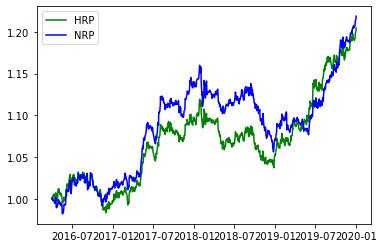

In [5]:
date = result['leverage_nrp.lev_df'].sort_index()['date'].values.get()
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_hrp.lev_df'].sort_index()['portfolio'].values)).get(), color='g', label='HRP')
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_nrp.lev_df'].sort_index()['portfolio'].values)).get(), color='b', label='NRP')
pl.legend()

Organize all the performance metrics in a table

In [6]:
nrp_metrics = [result['performance_nrp.sd_df']['portfolio'].values.item(),
               result['performance_nrp.ret_df']['portfolio'].values.item(),
               result['performance_nrp.maxdd_df']['portfolio'].values.item(),
               result['performance_nrp.calmar_df']['portfolio'].values.item(),
               result['performance_nrp.sharpe_df']['portfolio'].values.item()]
hrp_metrics = [result['performance_hrp.sd_df']['portfolio'].values.item(),
               result['performance_hrp.ret_df']['portfolio'].values.item(),
               result['performance_hrp.maxdd_df']['portfolio'].values.item(),
               result['performance_hrp.calmar_df']['portfolio'].values.item(),
               result['performance_hrp.sharpe_df']['portfolio'].values.item()]
metrics = ['SD', 'RET', 'MDD', 'Calmar', 'SR']
df = cudf.DataFrame({'metrics': metrics, 'NRP': nrp_metrics, 'HRP': hrp_metrics})
df.set_index('metrics')

,NRP,HRP
metrics,,
SD,0.051192,0.049698
RET,0.054139,0.050881
MDD,0.089418,0.073408
Calmar,0.605463,0.693130
SR,1.057562,1.023803


## Robustness of the strategies

Bootstrapped dataset To account for the non-stationarity of futures return time series, we generate an additional dataset of time-series by block bootstrapping (Hall (1985), Carlstein and others(1986), Fengler and Schwendner(2004) and Lohre, Rother, and Schaefer (2020)):

* Blocks with a fixed length, but a random starting point in time are defined from the futures return time-series. One block corresponds to 60 business days. This block length is motivated by a typical monthly or quarterly rebalancing frequency of dynamic rule-based strategies and by the empiricalmarket dynamicsthat happen on this time scale. Papenbrock and Schwendner (2015) found multi-asset correlation patterns to change at a typical frequency of a few months.
* A new return time-series is constructed by sampling the blocks with replacement to reconstruct a time-series with the same length of the original time-series. 

We added a Bootstrap Node to accelerate the bootstrap computation in the GPU. Run 4096 bootstrap samples, we can build a distribution of the performance metrics. Following is the workflow of running the bootstrap.

In [7]:
taskGraph=TaskGraph.load_taskgraph('./10assets/workflow_bootstrap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

Collect the results and list all the result keys:

In [8]:
result = taskGraph.run()
result.get_keys()

('hrp_nrp_diff.out',
 'performance_nrp.ret_df',
 'performance_nrp.sd_df',
 'performance_nrp.sharpe_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.maxdd_df')

Draw the performance statistics distribution:

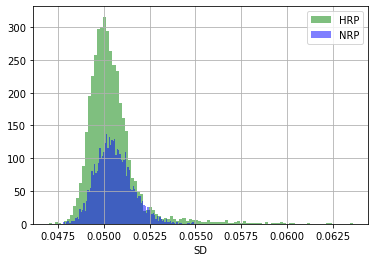

In [9]:
result['performance_hrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SD')
pl.legend()

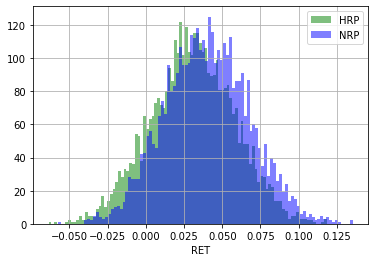

In [10]:
result['performance_hrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('RET')
pl.legend()

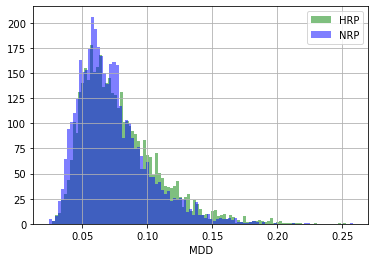

In [11]:
result['performance_hrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('MDD')
pl.legend()

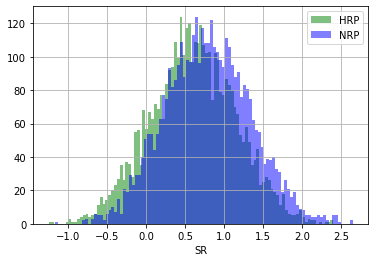

In [12]:
result['performance_hrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SR')
pl.legend()

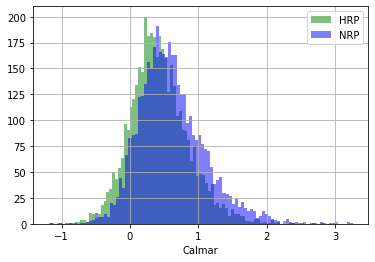

In [13]:
result['performance_hrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('Calmar')
pl.legend()

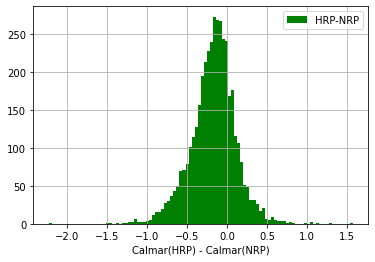

In [14]:
result['hrp_nrp_diff.out'].to_pandas()['portfolio'].hist(bins=100, color='g', label='HRP-NRP')
pl.xlabel('Calmar(HRP) - Calmar(NRP)')
pl.legend()

## Interpretable Machine Learning
In this section, we train a supervised learningmodel to fit the spread between the Calmar ratios of HRP and the NRP using statistical features of the bootstrapped
datasets. 

**The features**

To characterize the portfolio universe, we select a set of classical statistical features plus a set of quantities that can indicate properties of the hierarchical structure of the asset universe. This particular set of features is tailored to both strategies, and without the help of ML it would be quite difficult to link them to the performances of the strategies. We also look at some features that encode non-stationarity properties. Whenever the feature name has the suffix `_std`., we measure the standard deviation of the statistical property across time. That helps to identify the heterogeneity of that property acrossthe years. 

In total, we use 30 features associated with the portfolio universe. For example, X_mean_mean identifies the mean across assets of the mean returns across time. In other words, it provides information regarding the overall trend of the returns of the full portfolio. The `X_mean_mean_std` instead represents how the overall trend changes across years and is measured by the standard deviation of the `X_mean_means` measured year by year. Another feature is `X_mean_std` that measures the heterogeneity of the returns across the assets. A high value of this quantity means that the overall trend of the returns is characterized by a very heterogeneous behaviour across assets (in general features that have names ending with `X_std` have been measured with the standard deviation of X across assets).  `corr_mean` is the mean of the entries of the correlation matrix (only the lower diagonal terms) and together with `corr_std` (their standard deviation) they provide information on the independence of the asset from the rest of the universe. For example, a negative value of `corr_mean` suggests that there is a high number of assets that are anti-correlated. A value close to zero can represent either a portfolio with independent assets or one with the same degree of positive and negative correlations. In this case, `corr_std` would discriminate between the two possibilities. 

Following is the workflow to calcuate all the features for each bootstrap sample in the GPU

In [15]:

taskGraph=TaskGraph.load_taskgraph('./10assets/feature_computation_workflow.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

In [16]:
del result
result = taskGraph.run()
result['merge_features.merged']

Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?


,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,2688,0.170121,0.170121,0.237050,0.237050,0.000494,0.000494,0.014307,0.014307,-1.001798,...,0.275280,0.275280,0.484140,0.484140,0.000509,0.000509,0.014105,0.014105,-0.990131,-0.990131
1,2689,0.163747,0.163747,0.234264,0.234264,0.000523,0.000523,0.013214,0.013214,-1.008856,...,0.306150,0.306150,0.536543,0.536543,0.000566,0.000566,0.014297,0.014297,-1.003185,-1.003185
2,2690,0.175769,0.175769,0.200272,0.200272,0.000214,0.000214,0.013350,0.013350,-1.017879,...,0.299262,0.299262,0.384499,0.384499,0.000182,0.000182,0.013384,0.013384,-1.008019,-1.008019
3,2691,0.210016,0.210016,0.212407,0.212407,-0.000009,-0.000009,0.014882,0.014882,-1.023804,...,0.394223,0.394223,0.377784,0.377784,0.000086,0.000086,0.015330,0.015330,-1.012329,-1.012329
4,2692,0.189612,0.189612,0.203524,0.203524,0.000108,0.000108,0.014254,0.014254,-1.019671,...,0.345415,0.345415,0.402616,0.402616,0.000079,0.000079,0.014740,0.014740,-1.007813,-1.007813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,2491,0.181143,0.181143,0.195543,0.195543,0.000105,0.000105,0.012965,0.012965,-1.016399,...,0.327511,0.327511,0.385914,0.385914,0.000201,0.000201,0.013262,0.013262,-1.006468,-1.006468
4092,2492,0.176913,0.176913,0.214470,0.214470,0.000240,0.000240,0.014202,0.014202,-1.025738,...,0.301344,0.301344,0.435985,0.435985,0.000206,0.000206,0.015273,0.015273,-1.011802,-1.011802
4093,2493,0.166219,0.166219,0.228395,0.228395,0.000459,0.000459,0.012678,0.012678,-1.019380,...,0.323853,0.323853,0.485112,0.485112,0.000317,0.000317,0.013293,0.013293,-1.018051,-1.018051
4094,2494,0.196814,0.196814,0.203446,0.203446,-0.000007,-0.000007,0.014573,0.014573,-1.014329,...,0.359245,0.359245,0.430040,0.430040,0.000052,0.000052,0.014706,0.014706,-0.991897,-0.991897


The taskgrpah is a bit complicated, we can use `CompositeNode` to group the sub-graph into a single node. Here is a simplfied version of it:

In [19]:
taskGraph=TaskGraph.load_taskgraph('./10assets/all_feature_simplified.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

In [21]:
del result
result = taskGraph.run()
result['merge_features.merged']

Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?


,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,2688,0.188838,0.188838,0.235075,0.235075,0.000253,0.000253,0.014521,0.014521,-1.010188,...,0.305677,0.305677,0.518541,0.518541,0.000306,0.000306,0.014672,0.014672,-1.003229,-1.003229
1,2689,0.191705,0.191705,0.206052,0.206052,0.000091,0.000091,0.013261,0.013261,-0.984908,...,0.399683,0.399683,0.407706,0.407706,0.000155,0.000155,0.013553,0.013553,-0.978168,-0.978168
2,2690,0.192693,0.192693,0.208275,0.208275,0.000120,0.000120,0.013617,0.013617,-0.994928,...,0.360825,0.360825,0.423275,0.423275,0.000095,0.000095,0.015142,0.015142,-0.981526,-0.981526
3,2691,0.192090,0.192090,0.205622,0.205622,0.000134,0.000134,0.013898,0.013898,-1.005028,...,0.351473,0.351473,0.417076,0.417076,0.000219,0.000219,0.014210,0.014210,-0.993411,-0.993411
4,2692,0.208334,0.208334,0.190023,0.190023,-0.000220,-0.000220,0.015305,0.015305,-0.979645,...,0.370233,0.370233,0.385966,0.385966,-0.000197,-0.000197,0.015527,0.015527,-0.974628,-0.974628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,2491,0.174520,0.174520,0.212863,0.212863,0.000265,0.000265,0.013519,0.013519,-0.987158,...,0.315698,0.315698,0.426006,0.426006,0.000116,0.000116,0.013994,0.013994,-0.975892,-0.975892
4092,2492,0.179919,0.179919,0.224197,0.224197,0.000274,0.000274,0.013910,0.013910,-1.001182,...,0.347497,0.347497,0.465325,0.465325,0.000307,0.000307,0.014429,0.014429,-0.986496,-0.986496
4093,2493,0.172228,0.172228,0.230245,0.230245,0.000362,0.000362,0.013987,0.013987,-1.004242,...,0.288631,0.288631,0.506092,0.506092,0.000364,0.000364,0.014655,0.014655,-0.995258,-0.995258
4094,2494,0.167227,0.167227,0.232734,0.232734,0.000468,0.000468,0.013859,0.013859,-1.017293,...,0.298859,0.298859,0.527868,0.527868,0.000476,0.000476,0.014304,0.014304,-1.011702,-1.011702


## The ML learning model

For the supervised learning algorithm, we selected XGBoost (Chen and Guestrin (2016)) , a gradient tree boosting library that is fast and accurate as described in the paper. This algorithm can construct non-linear relations among the features. Moreover, for large datasets, it can scale across GPUs to speed-up the learning process. Another benefit of using XGBoost is that it produces fast explanations.

To assess the stability of the explanations, the set of bootstrapped datasets, each across 17 multi-asset futures, is split into 90% training and 10% test set. We trained the model as a regression, to learn the difference between theCalmarratio obtained with HRP minusthe Calmar ratio obtained by HRP. 

In [22]:
taskGraph=TaskGraph.load_taskgraph('./10assets/xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

Run and collect the results:

In [23]:
del result
result = taskGraph.run()

Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?


Let's check the R-squared score for both Train dataset and Test dataset

In [24]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.9974474295705986 Test R-Squared: 0.19090992124659914


Text(0.5, 1.0, 'Test')

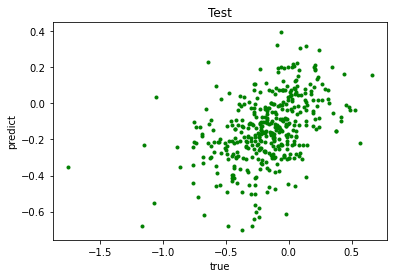

In [25]:
pl.plot(result['test_infer.out'].portfolio.values.get(), result['test_infer.out'].predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

Text(0.5, 1.0, 'Train')

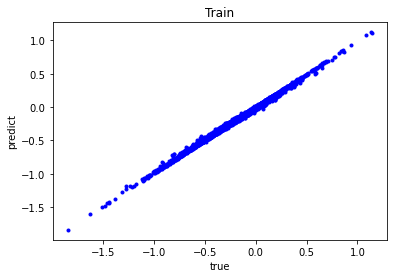

In [26]:
pl.plot(result['train_infer.out'].portfolio.values.get(), result['train_infer.out'].predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Clearly the XGBoost model is overfitted as we only use 4096 datapoints. We will use more datapoints later

## The explanation method

We will use Shapley values of feature contribution to explain the ML result. In simple words, what Shapley values tell us is how much each feature (the statistical properties ofthe asset universe described above) has contributed to a specific outcome of theML model. Because of the complexity (non-linearity) of the model, this is a non-trivial task. The Shapley value is a quantity introduced in co-operative game theory to provide the fair payout to a player (the features) with respect to its contribution to the common goal (ML prediction). The SHAP framework (Lundberg and Lee (2017)) provides a tool to evaluate this quantity even in a model agnostic way. It allows comparing these quantitative explanations among different models.

Shapley values can be computed from the XGboost inference node. Following is the workflow to visualize the feature contributions. 

In [27]:
taskGraph=TaskGraph.load_taskgraph('./10assets/xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?


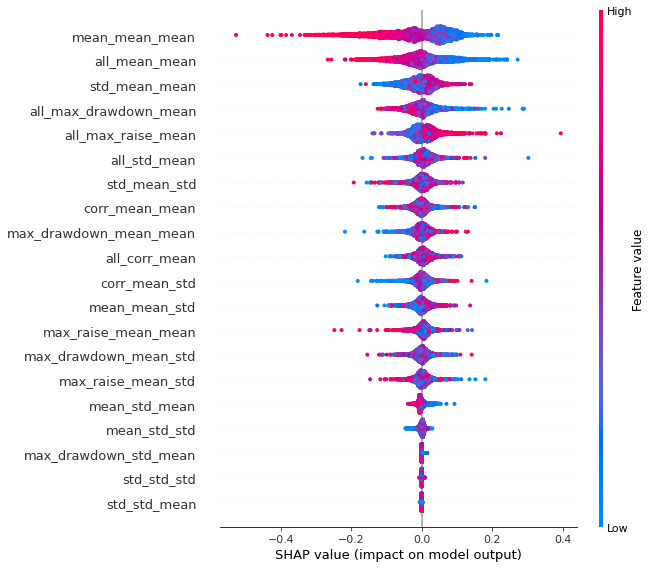

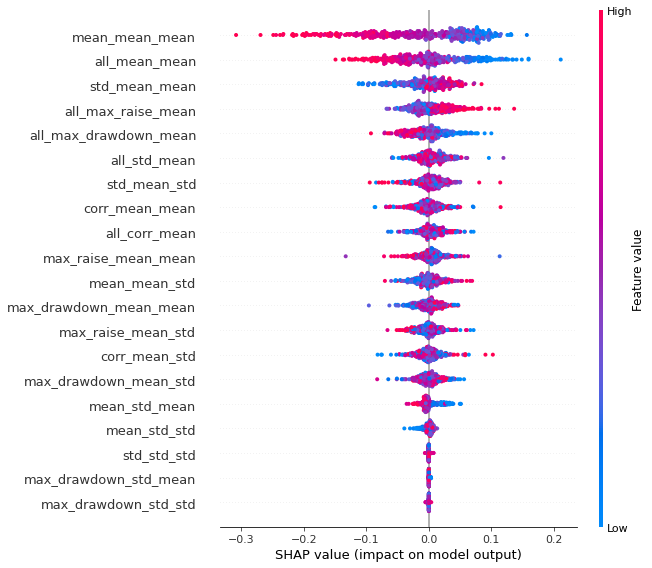

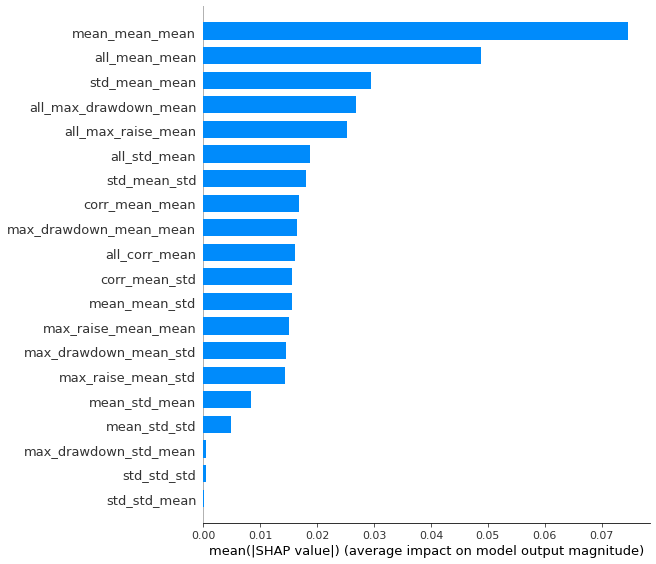

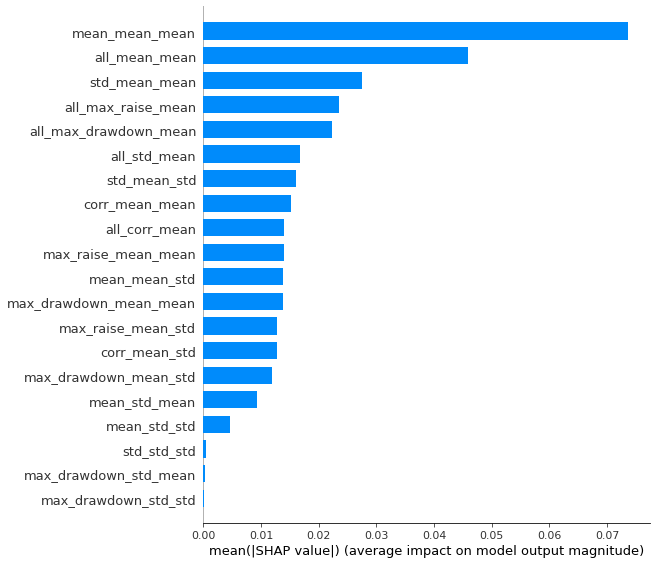

In [28]:
del result
result = taskGraph.run()

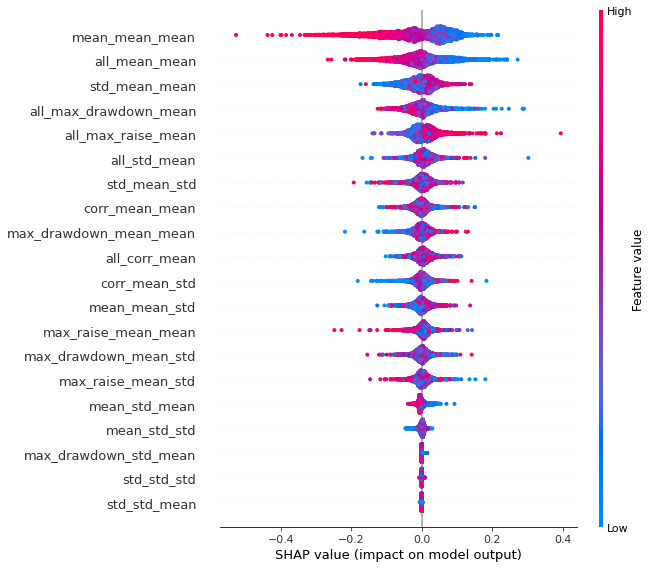

In [29]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

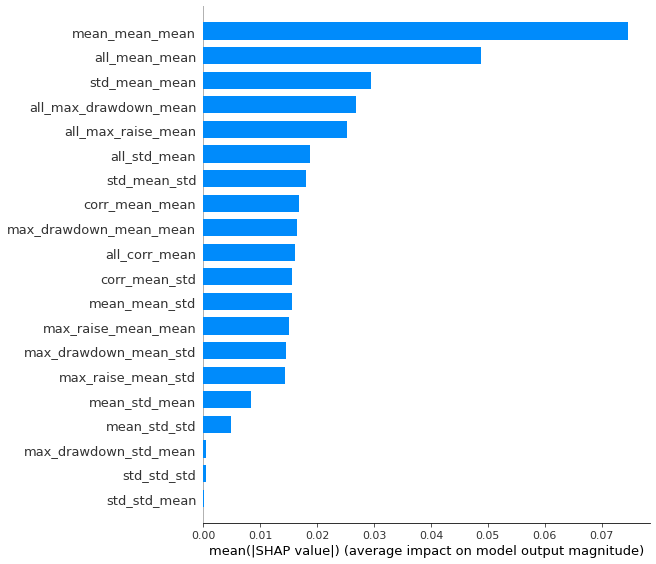

In [30]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

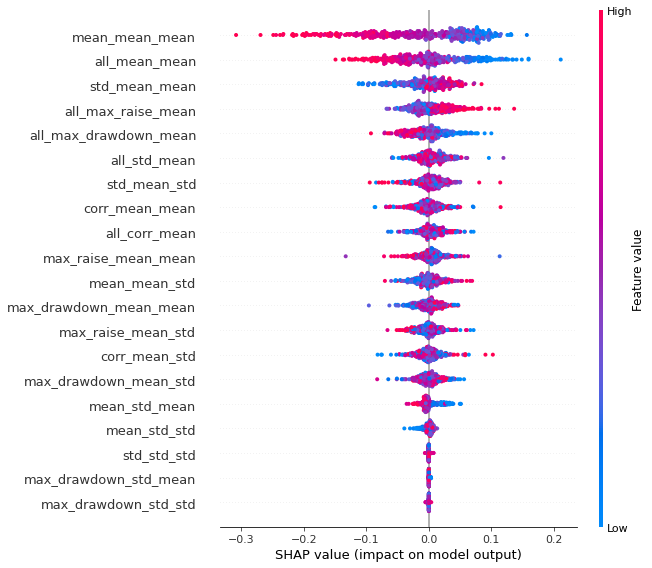

In [31]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

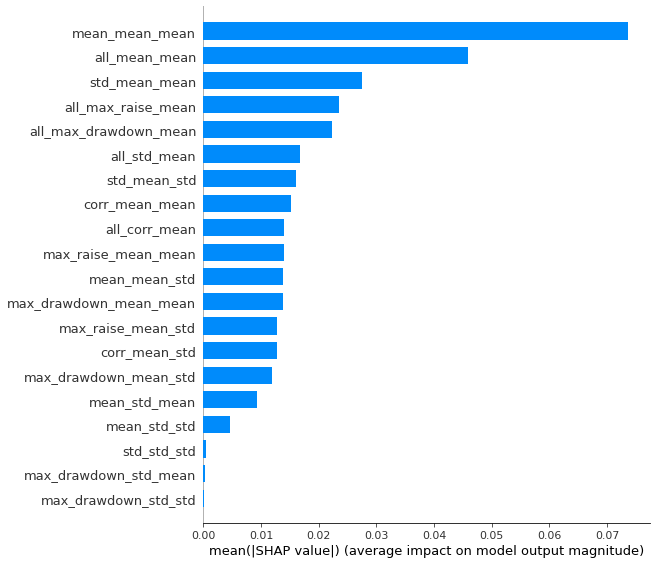

In [32]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

## Scale to 100K Samples

The maximum number of samples that can be computed in a single 32G V100 GPU is 4096. To compute 100K samples, we use Dask to distribute the workloads in multiple GPUs.


In [33]:
taskGraph=TaskGraph.load_taskgraph('./10assets/parallel_xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

CPU times: user 17.7 s, sys: 931 ms, total: 18.6 s
Wall time: 1min 14s


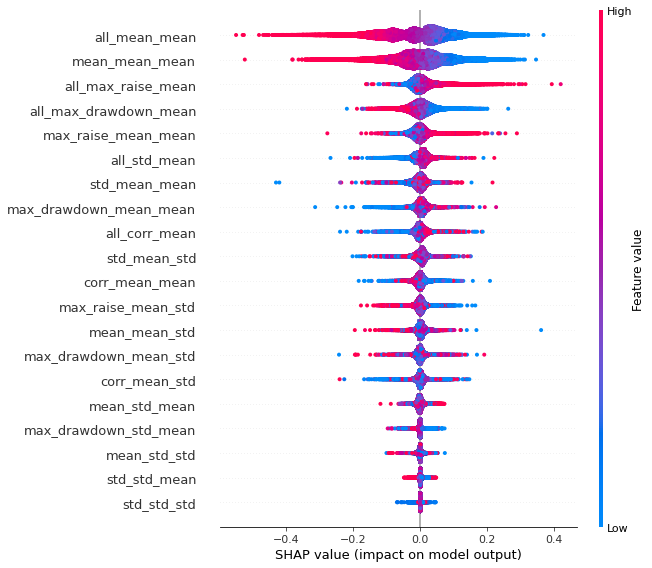

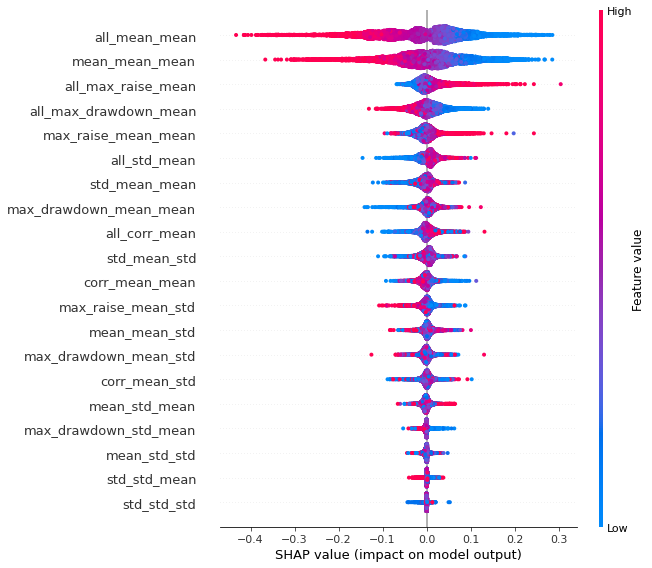

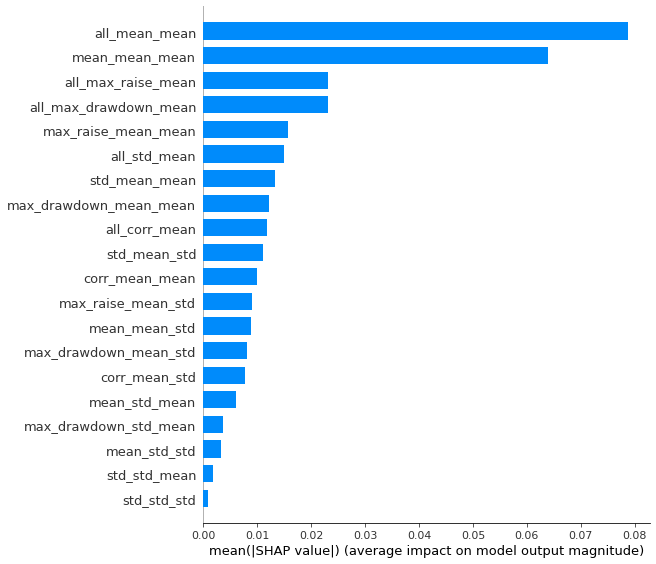

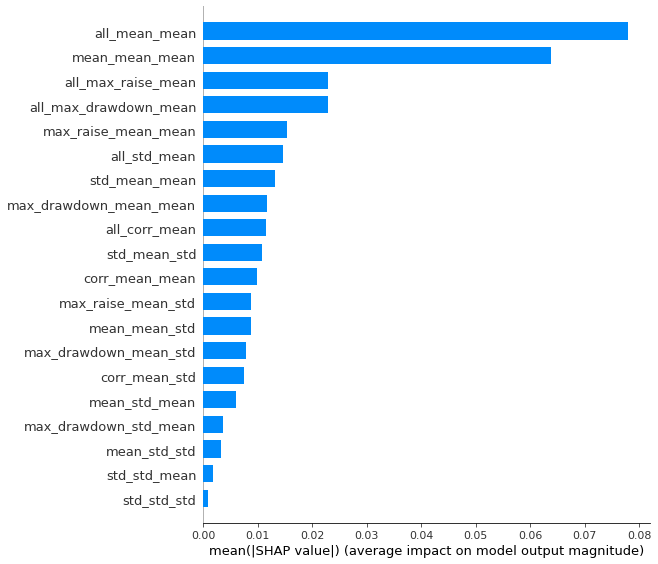

In [34]:
del result
%time result = taskGraph.run()

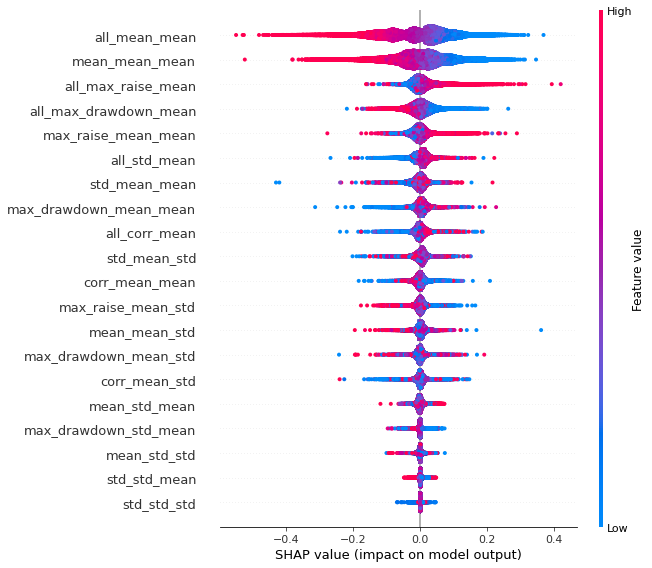

In [35]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

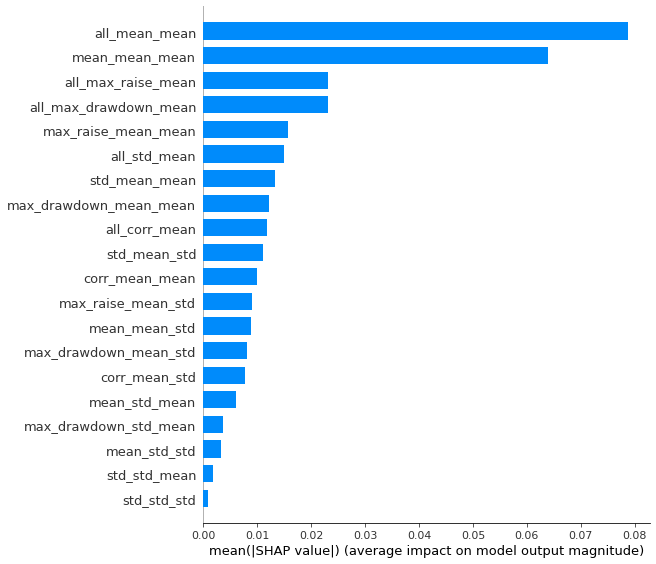

In [36]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

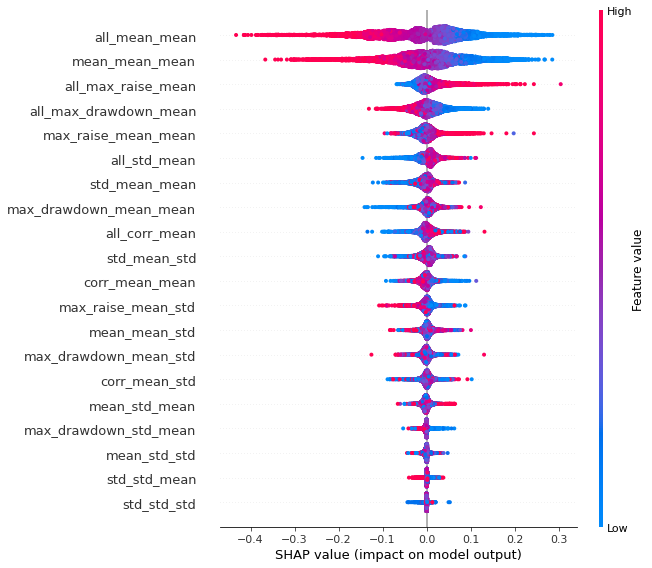

In [37]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

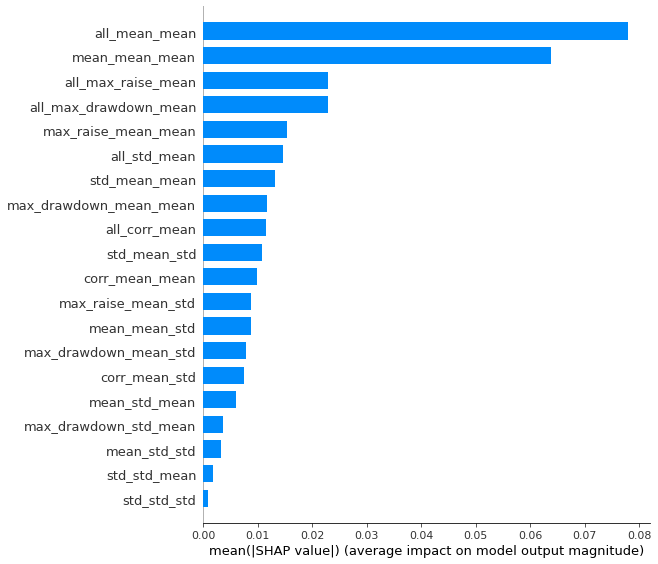

In [38]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

We run the XGboost performance metrics again for 100K samples:

In [40]:
taskGraph=TaskGraph.load_taskgraph('./10assets/parallel_xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

In [41]:
%time result = taskGraph.run()

CPU times: user 9.47 s, sys: 558 ms, total: 10 s
Wall time: 1min


In [42]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.6061295311101064 Test R-Squared: 0.19817927921542997


In [43]:
train_infer_df = result['train_infer.out'].compute()
test_infer_df = result['test_infer.out'].compute()

Text(0.5, 1.0, 'Train')

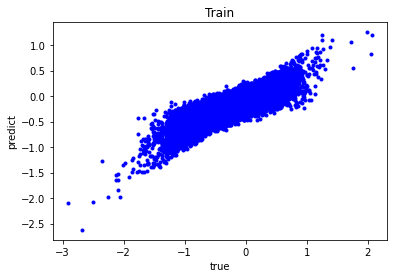

In [44]:
pl.plot(train_infer_df.portfolio.values.get(), train_infer_df.predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Text(0.5, 1.0, 'Test')

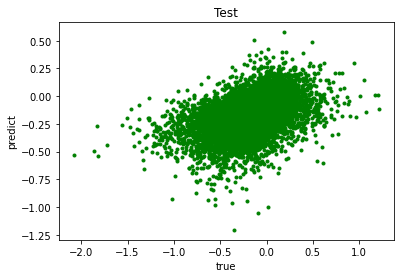

In [45]:
pl.plot(test_infer_df.portfolio.values.get(), test_infer_df.predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

## Hyperparameter Optimization

When data scientists are building machine learning models, there are a few magic numbers that are included in the model. The example numbers are depths in the tree, the learning rate, etc. The parameters that define the model architecture or training process are usually referred to as hyperparameters. They are magical because there is no good theory about what number to choose. Commonly, the hyperparameters can be searched to find a good set of them that results in the best model performance. The process of searching is referred to as hyperparameter tuning.

There are a few popular Python-based hyperparameter tuning libraries existing: Ray Tune, Optuna, HyperOpt. Each library provides a set of search algorithms and schedule algorithms that is easy to use.

Inside the `greenflow` project, we implemented a Context Composite Node that can flexibly expose the hyperparameters that are interesting for tuning. The Context Composite Node makes hyperparameter tuning easy to do by leveraging the hyperparameter tuning libraries. Inside `greenflow_gquant_plugin` project, there is a `GridRandomSearchNode` that can do random and grid search with Ray Tune library for the hyperparameters. First, we need to initialize the ray tune environment.

In [46]:
import ray
ray.init()

2021-02-26 11:16:33,207	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.110.106.133',
 'raylet_ip_address': '10.110.106.133',
 'redis_address': '10.110.106.133:6379',
 'object_store_address': '/tmp/ray/session_2021-02-26_11-16-32_226562_5903/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-26_11-16-32_226562_5903/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-26_11-16-32_226562_5903',
 'metrics_export_port': 63277,
 'node_id': '57a2324b1938f197a39266e3388ebe473ebe4a17'}

Following is the workflow to run HPO. As a simple example, we will search the `num_rounds` and `eta` parameters in the XGBoost model. We use grid search for `num_rounds` and random search for `eta`. Click on the `GridRandomSearchNode`, you can see how we configure the search space.

In [47]:
taskGraph=TaskGraph.load_taskgraph('./10assets/hpo.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'xgboost_train'), ('type', 'ContextCompositeNode'), ('c…

In [48]:
taskGraph.run()

get best {'eta': 0.11659227783645121, 'num_rounds': 120}
get best {'eta': 0.11659227783645121, 'num_rounds': 120}
get best {'eta': 0.11659227783645121, 'num_rounds': 120}


Trial name,status,loc,eta,num_rounds
search_fun_317a5_00000,RUNNING,,0.327672,100


(pid=6922) Port 8787 is already in use.
(pid=6922) Perhaps you already have a cluster running?
(pid=6922) Hosting the HTTP server on port 34125 instead


(pid=6922) start new Cluster


(pid=6922) [11:18:05] task [xgboost.dask]:tcp://127.0.0.1:42127 got new rank 0
(pid=6922) [11:18:05] task [xgboost.dask]:tcp://127.0.0.1:36413 got new rank 1
(pid=6922) [11:18:05] task [xgboost.dask]:tcp://127.0.0.1:42519 got new rank 2
(pid=6922) [11:18:06] task [xgboost.dask]:tcp://127.0.0.1:41251 got new rank 3


Result for search_fun_317a5_00000:
  date: 2021-02-26_11-18-12
  done: false
  experiment_id: f5c8ada8ffeb4e81b7d361fca440a3a2
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 6922
  test_rsquared.out: 0.2038782015759438
  time_since_restore: 73.25002956390381
  time_this_iter_s: 73.25002956390381
  time_total_s: 73.25002956390381
  timestamp: 1614367092
  timesteps_since_restore: 0
  train_rsquared.out: 0.6195040157043019
  training_iteration: 1
  trial_id: 317a5_00000
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_317a5_00000,RUNNING,10.110.106.133:6922,0.327672,100,1,73.25,0.619504,0.203878
search_fun_317a5_00001,PENDING,,0.43257,110,,,,


Result for search_fun_317a5_00000:
  date: 2021-02-26_11-18-12
  done: true
  experiment_id: f5c8ada8ffeb4e81b7d361fca440a3a2
  experiment_tag: 0_eta=0.32767,num_rounds=100
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 6922
  test_rsquared.out: 0.2038782015759438
  time_since_restore: 73.25002956390381
  time_this_iter_s: 73.25002956390381
  time_total_s: 73.25002956390381
  timestamp: 1614367092
  timesteps_since_restore: 0
  train_rsquared.out: 0.6195040157043019
  training_iteration: 1
  trial_id: 317a5_00000
  


(pid=6922) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6922) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6922) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6922) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6922) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6922) T

(pid=6921) start new Cluster


(pid=6921) [11:19:20] task [xgboost.dask]:tcp://127.0.0.1:44493 got new rank 0
(pid=6921) [11:19:20] task [xgboost.dask]:tcp://127.0.0.1:34737 got new rank 1
(pid=6921) [11:19:20] task [xgboost.dask]:tcp://127.0.0.1:35421 got new rank 2
(pid=6921) [11:19:20] task [xgboost.dask]:tcp://127.0.0.1:42575 got new rank 3


Result for search_fun_317a5_00001:
  date: 2021-02-26_11-19-27
  done: false
  experiment_id: 6d9b7a6bc4d1488db9cbdcf01799a36a
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 6921
  test_rsquared.out: 0.15395543036608952
  time_since_restore: 72.58541822433472
  time_this_iter_s: 72.58541822433472
  time_total_s: 72.58541822433472
  timestamp: 1614367167
  timesteps_since_restore: 0
  train_rsquared.out: 0.6959605558818889
  training_iteration: 1
  trial_id: 317a5_00001
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_317a5_00001,RUNNING,10.110.106.133:6921,0.43257,110,1,72.5854,0.695961,0.153955
search_fun_317a5_00002,PENDING,,0.125677,120,,,,
search_fun_317a5_00000,TERMINATED,,0.327672,100,1,73.25,0.619504,0.203878


Result for search_fun_317a5_00001:
  date: 2021-02-26_11-19-27
  done: true
  experiment_id: 6d9b7a6bc4d1488db9cbdcf01799a36a
  experiment_tag: 1_eta=0.43257,num_rounds=110
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 6921
  test_rsquared.out: 0.15395543036608952
  time_since_restore: 72.58541822433472
  time_this_iter_s: 72.58541822433472
  time_total_s: 72.58541822433472
  timestamp: 1614367167
  timesteps_since_restore: 0
  train_rsquared.out: 0.6959605558818889
  training_iteration: 1
  trial_id: 317a5_00001
  


(pid=6921) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6921) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6921) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6921) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6921) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6921) T

(pid=6915) start new Cluster


(pid=6915) [11:20:36] task [xgboost.dask]:tcp://127.0.0.1:34259 got new rank 0
(pid=6915) [11:20:36] task [xgboost.dask]:tcp://127.0.0.1:41909 got new rank 1
(pid=6915) [11:20:36] task [xgboost.dask]:tcp://127.0.0.1:34999 got new rank 2
(pid=6915) [11:20:36] task [xgboost.dask]:tcp://127.0.0.1:34185 got new rank 3


Result for search_fun_317a5_00002:
  date: 2021-02-26_11-20-44
  done: false
  experiment_id: 0060cdd902f742dfbde058125d04e2fe
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 6915
  test_rsquared.out: 0.24299914291579713
  time_since_restore: 73.72612190246582
  time_this_iter_s: 73.72612190246582
  time_total_s: 73.72612190246582
  timestamp: 1614367244
  timesteps_since_restore: 0
  train_rsquared.out: 0.4915739083167703
  training_iteration: 1
  trial_id: 317a5_00002
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_317a5_00002,RUNNING,10.110.106.133:6915,0.125677,120,1,73.7261,0.491574,0.242999
search_fun_317a5_00000,TERMINATED,,0.327672,100,1,73.25,0.619504,0.203878
search_fun_317a5_00001,TERMINATED,,0.43257,110,1,72.5854,0.695961,0.153955


Result for search_fun_317a5_00002:
  date: 2021-02-26_11-20-44
  done: true
  experiment_id: 0060cdd902f742dfbde058125d04e2fe
  experiment_tag: 2_eta=0.12568,num_rounds=120
  hostname: dgx-rpd-05
  iterations_since_restore: 1
  node_ip: 10.110.106.133
  pid: 6915
  test_rsquared.out: 0.24299914291579713
  time_since_restore: 73.72612190246582
  time_this_iter_s: 73.72612190246582
  time_total_s: 73.72612190246582
  timestamp: 1614367244
  timesteps_since_restore: 0
  train_rsquared.out: 0.4915739083167703
  training_iteration: 1
  trial_id: 317a5_00002
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_317a5_00000,TERMINATED,,0.327672,100,1,73.25,0.619504,0.203878
search_fun_317a5_00001,TERMINATED,,0.43257,110,1,72.5854,0.695961,0.153955
search_fun_317a5_00002,TERMINATED,,0.125677,120,1,73.7261,0.491574,0.242999


2021-02-26 11:20:44,165	INFO tune.py:448 -- Total run time: 226.99 seconds (226.92 seconds for the tuning loop).
(pid=6915) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6915) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6915) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6915) Task "all_max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.FeatureNode'>]" missing required port "feature_df" in incoming meta data. Should the port be connected?
(pid=6915) Task "max_drawdown_feature" Node Type "[<class 'greenflow_hrp_plugin.featureNode.Fea

get best {'eta': 0.12567743991944214, 'num_rounds': 120}


Results([('grid_search.conf_out', <greenflow.plugin_nodes.util.data_obj.ConfData object at 0x7f29e6685370>), ('grid_search.test_rsquared@out', 0.24019525618675888)])

In above simple HPO run, we see more rounds in the XGBoost training help to increase the test R-squared score. HPO is a time consuming process, GPU make it possible as we reduce the time to run 100K bootstrap samples from days in CPU cluter to 4 mins in DGX station. Feel free to add more hyperparamerters and increase the number of trails in above workflow.